   # Part2 - LQR to stay in place

In [14]:
#Using all the content from quadrotor.py

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import matplotlib.animation as animation
import IPython


MASS = 0.600 # mass of the quadrotor
INERTIA = 0.15 # inertia of the quadrotor
        
LENGTH = 0.2 # length of the quadrotor
        
GRAVITY=9.81 #gravity constant

DELTA_T = 0.01 #integration step
        
NUMBER_STATES = 6 # number of states
NUMBER_CONTROLS = 2 # number of controls
        
            
def get_next_state(z,u):
    """
    Inputs:
    z: state of the quadrotor as a numpy array (x, vx, y, vy, theta, omega)
    u: control as a numpy array (u1, u2)

    Output:
    the new state of the quadrotor as a numpy array
    """
    x = z[0]
    vx = z[1]
    y = z[2]
    vy = z[3]
    theta = z[4]
    omega = z[5]

    dydt = np.zeros([NUMBER_STATES,])
    dydt[0] = vx
    dydt[1] = (-(u[0] + u[1]) * np.sin(theta)) / MASS
    dydt[2] = vy
    dydt[3] = ((u[0] + u[1]) * np.cos(theta) - MASS * GRAVITY) / MASS
    dydt[4] = omega
    dydt[5] = (LENGTH * (u[0] - u[1])) / INERTIA

    z_next = z + dydt * DELTA_T

    return z_next


    
def simulate(z0, controller, horizon_length, disturbance = False):
    """
    This function simulates the quadrotor for horizon_length steps from initial state z0

    Inputs:
    z0: the initial conditions of the quadrotor as a numpy array (x, vx, y, vy, theta, omega)
    controller: a function that takes a state z as argument and index i of the time step and returns a control u
    horizon_length: the horizon length

    disturbance: if True will generate a random push every seconds during the simulation

    Output:
    t[time_horizon+1] contains the simulation time
    z[4, time_horizon+1] and u[2, time_horizon] containing the time evolution of states and control
    """
    
    t = np.zeros([horizon_length+1,])
    z=np.empty([NUMBER_STATES, horizon_length+1])
    z[:,0] = z0
    u=np.zeros([NUMBER_CONTROLS, horizon_length])
    for i in range(horizon_length):
        u[:,i] = controller(z[:,i],i)
        z[:,i+1] = get_next_state(z[:,i], u[:,i])
        if disturbance and np.mod(i,100)==0:
            dist = np.zeros([NUMBER_STATES, ])
            dist[1::2] = np.random.uniform(-1.,1,(3,))
            z[:,i+1] += dist
        t[i+1] = t[i] + DELTA_T
    return t, z, u
    
    
def animate_robot(x, u, dt = 0.01):
    """
    This function makes an animation showing the behavior of the quadrotor
    takes as input the result of a simulation (with dt=0.01s)
    """

    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(np.round(min_dt * 1000))
    else:
        steps = 1
        use_dt = int(np.round(dt * 1000))

    #what we need to plot
    plotx = x[:,::steps]
    plotx = plotx[:,:-1]
    plotu = u[:,::steps]

    fig = mp.figure.Figure(figsize=[8.5,8.5])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4,4], ylim=[-4,4])
    ax.grid()

    list_of_lines = []

    #create the robot
    # the main frame
    line, = ax.plot([], [], 'k', lw=6)
    list_of_lines.append(line)
    # the left propeller
    line, = ax.plot([], [], 'b', lw=4)
    list_of_lines.append(line)
    # the right propeller
    line, = ax.plot([], [], 'b', lw=4)
    list_of_lines.append(line)
    # the left thrust
    line, = ax.plot([], [], 'r', lw=1)
    list_of_lines.append(line)
    # the right thrust
    line, = ax.plot([], [], 'r', lw=1)
    list_of_lines.append(line)

    def _animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])

        theta = plotx[4,i]
        x = plotx[0,i]
        y = plotx[2,i]
        trans = np.array([[x,x],[y,y]])
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        main_frame = np.array([[-LENGTH, LENGTH], [0,0]])
        main_frame = rot @ main_frame + trans 

        left_propeller = np.array([[-1.3 * LENGTH, -0.7*LENGTH], [0.1,0.1]])
        left_propeller = rot @ left_propeller + trans

        right_propeller = np.array([[1.3 * LENGTH, 0.7*LENGTH], [0.1,0.1]])
        right_propeller = rot @ right_propeller + trans

        left_thrust = np.array([[LENGTH, LENGTH], [0.1, 0.1+plotu[0,i]*0.04]])
        left_thrust = rot @ left_thrust + trans

        right_thrust = np.array([[-LENGTH, -LENGTH], [0.1, 0.1+plotu[0,i]*0.04]])
        right_thrust = rot @ right_thrust + trans

        list_of_lines[0].set_data(main_frame[0,:], main_frame[1,:])
        list_of_lines[1].set_data(left_propeller[0,:], left_propeller[1,:])
        list_of_lines[2].set_data(right_propeller[0,:], right_propeller[1,:])
        list_of_lines[3].set_data(left_thrust[0,:], left_thrust[1,:])
        list_of_lines[4].set_data(right_thrust[0,:], right_thrust[1,:])

        return list_of_lines

    def _init():
        return _animate(0)


    ani = animation.FuncAnimation(fig, _animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=_init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [15]:
#implementing get_linearization
def get_linearization(z,u):
    #initializing A and B
    
    A=np.identity(6)
    A[0,1]=DELTA_T
    A[1,4]=-(1/MASS)*(u[0]+u[1])*np.cos(z[4])*DELTA_T
    A[2,3]=DELTA_T
    A[3,4]=-(1/MASS)*(u[0]+u[1])*np.sin(z[4])*DELTA_T
    A[4,5]=DELTA_T
    
    
    B=np.zeros(shape=(6,2))
    B[1,0]=-np.sin(z[4])*DELTA_T/MASS
    B[1,1]=-(np.sin(z[4])*DELTA_T)/MASS
    B[3,0]=(np.cos(z[4])*DELTA_T)/MASS
    B[3,1]=(np.cos(z[4])*DELTA_T)/MASS
    B[-1,0]=LENGTH*DELTA_T/INERTIA
    B[-1,1]=-LENGTH*DELTA_T/INERTIA

    return A,B

In [16]:
#solve_LQR
def solve_LQR(A, B, Q, R, QN, N):
    
    list_of_P = []
    list_of_K = []
    list_of_P.append(QN)
    for i in range(N):
        Kn=-1.0 * np.linalg.inv(B.transpose().dot(list_of_P[i]).dot(B) + R).dot(B.transpose()).dot(list_of_P[i]).dot(A)
        Pn = Q + A.transpose().dot(list_of_P[i]).dot(A) + A.transpose().dot(list_of_P[i]).dot(B).dot(Kn)
        list_of_P.append(Pn)
        list_of_K.append(Kn)
    return list_of_P[::-1], list_of_K[::-1]

In [10]:
#implementing a controller to pass it into simulate
def quad_moving(state,i):
    z_star,u_star = np.transpose(np.array([0,0,0,0,0,0])),np.transpose(np.array([(MASS*9.81)/2, (MASS*9.81)/2]))
   
    A,B=get_linearization(z_star,u_star)
    Q=(np.identity(6))*100
    R=(np.identity(2))*0.0001
    P,K=solve_LQR(A,B,Q,R,Q,N=1000)
    u = K[i].dot(state - z_star) + u_star
    return u

In [11]:
z_star=np.transpose(np.array([0,0,0,0,0,0]))
t,state,u=simulate(z_star,quad_moving,horizon_length=1000,disturbance=)
animate_robot(state,u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABf1W1kYXQAAAKhBgX//53cRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU5IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxOSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEyIGxvb2thaGVhZF90aHJlYWRz
PTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j
b21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0
PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu
dD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo
ZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9
NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAEn9liIQAEf/+94gfMstp+TrX
chHnrS6tH1DuRnFepL3+IAAAAwAAAwAAAwAKklieIofxeM38AAADAAC3gBewDCAKqAwqPoh2d2dP
MAiJHr46cNtWROOk97EYcuOhdjfSGRcSFIT2QQogk1usCkIjgbveKEdmLhPUrWKiDlZzSnqksdOE
LAKadiFKpilhtOjafm1mOX1J6uxzeubFMJTVobl6NaV/ZmIE+0nq+5kR/oUJY96SuN/eI7GD2dh4
ALf/96RonpS6nykSdfvgC0XmaI8JeYZinVWAiUyFuUoTV/lcuXFvUdRea4b58SAMIAk2CCtJYygV
VLw4WloMMy9I7rimbOHq8cOgq1+ZwDiLXa5SyHuvA1l78Ejst1tpoKYWVoobqndaVlkE6AtzpeHo
oaoGT4NdMi/OacZ1oT+9hVmulCoTm1aUfXAvOmwJVeFoyHDIqUgdhcLMjnuE3UZeTkAmzvyQvcvS
4V3pz9EVxs4WbjLOSh7/uXaHrAQo7Pu4WAAF0AAAGBP9cvR5HyToneVEgZxOWGH8uBB6a8H0t444
9tL+Kj1sQqmS0zNSyvasfufuCf4BblrJfv449dOwlaLkB/pyX5CfPS5b4NgEtLmna2Femi8IOTnq
1zBbSmACafl9/aFdeYj0tATelYbP1q9mOdGMbhU3G9EPowkG6gYVnPRNmHgd6Ndf5evoBjU20uEb
kO3QUVPuF4PLZP8nnqy0KIuiVhoQLgux/cFr+bWrNZ8wQjIA2ntoM8qgwe9P1mMAq/sUFldfF/R3
eDx1OfilN/UZA8ZGZ/K1RDJAaZokC0KEvXmbcF9vZO1bX7eDNJnVLVGDgEflk8TbjPf2sX0Sg8Au
i7KOr+2SyYDTGe+U6rY1BDudAbL74edZoy/ryN5kt8iymceQZguVqIcfz7v+DFeSmmipttXMaRs4
sCVTG4HceRynmjPBEUkSR99iiQAAAwAAAwAAAwAABTorZZQCtNrF4n4UAjp4M6ULjVCsrd8do84D
pOSHv8PDGxhp5uLpnP+1zdfT4CE1/7/D+MVytE3Jo844RwHPES4Q8guy3QSV+MY/m/cAflfJcF9z
taJ2dgJmuxrBusupZObhCCgB1GAtXRTnnmL/zqQ06Ievjo3Dq2isqTWvuY21n9P9d7r4Tv4SNkcb
3QLJoQ9oZLeP/mZgeDcwDmtsSa88a6KwuA1lJYLVhWhNV4N450oZHgTZu1ZHqq/eoQ3FTKjyJkU3
hsJXiyDvJVN8K/5DVbCsPtMSQDVEEkBty4dVj/wKv2DXJPnkk2KXY/8s1pdhQhDDd1u4DQA+Txcc
shQEoX3tkA2wXtoZjADHn+VdnhV6GhTjFwTxGGUsUzhymn534qei3oA+TmQJAABu3dyzB/3xVCAR
ImQkkAD5JZIhABvymDtAQUIyIj19eUDlFyFtw3pyekKDi08JBBRDMRi4zDlNLAUGix5NKFUO9Qbw
eox4ieU2dJzfl2Dqpd2M/sS5ruFrOWGZNNzRVL1mhhG/A8Uvi1+5jTo3iINRmMhBuDtTvSxRFQcY
TEONjUY4/5Zod+2K6jCJjbBlzbNkFsk3og8YD4KF4x8Mm93U0s4Q/SjNdjDTe+dmz9b2ALFvV7bf
P+9eAq/t6cluiBNQcO/jPWAAGE/X9JdgdFCzIhFEmdlAc97mVAuWGTtkmwRgjNJUyUl56T5LKJK3
SW6vD7BZIxTp6Tbdlj7i34474s4FzjjT4PrmIYJpjXYyjrZBJG4jI4+ulIcvUyz+v5PrwTmGtvjH
L31uRXZfMiwPmEptfzf1/khGJ3m+OsVBit8SxTlgWwzKmKvE+7+L3/HdAQo7vNsEBuiGkOdGrHaI
MdIbtFBaYuddBqj3I3am17T5HvF+YbRe1AwZsxocjdLb9VwfvSDgAAOsc/kdq/PkAABJW+4agTNp
oAWKvktQhXz8dq+KCXLNPZOc0RPVQEz9oGt8IDMxkFcIsw3nynXJzjr2rrrPejCpU5eInPrq/rhc
sr9Zd4b/eeiKho9MKgTm5QeyVD2UoyprqXMtw6E74ilc+AGmY+I/NB2wTjjO8CAoHLqPVN2jk3c6
bOE6sxIKu/yn4iv/jMemun6Hz9Q1wg2/uYcJEQJnqLS4SRU5pFedGNlczMlfI8KE1JdGC7h0A9U2
odzI9LPFiX/xSR6xK/vU1peX4kk4TwCjO3lwkAAcrfeQbPgFoeVTVH/LthNxHwWI2FoxVKdrOlPV
+WD7CUz0gRBpihyNvX8etU15AMwGCmml0B5l60yH82w2yuFnUWdVDJvH5o+/uBUerzoX2LWvdfKy
FHq9ZzwGtZMJY+pgxlhN1yJp+11uFv0xg4nZ068D21N1iyB48v7RQoujdU65dfSTqxMV2oNp+Ah6
dQmYCyav9/YR7YAhPkdkfr1HpUCIpLbEWgTjr8AJojL/3awpLeIomS65aK3BNgIlKWiwKYuMNkgC
qqvyXQIqL576udlErSgV9OsBap6daDMYP8UNzbtUetZ7O+rvzC6NePF4oBnd7KCgm4nddsCqzzdA
ChtQs30q8oR/y2cCgsE9m9qTnPqsExNHyWdPJmLMHwVh2F6VgCrLWsInmFhqa1EDcp7hLJFpXLR8
JLC7/w4RgldJ/4mOnG3r4iBR4c9yDr+TVhOpop0ObfeLL8qLg6fzIXtxNd31nlo0nAsD7GRcnaaM
XXwYiq/H3z71SiCC9KT0kDj6/Iid3akBGm63jMkGJ59j9nU/eMGzq75H35P/QKfcj6CvtVIIU1QU
LYss0gH7ohJbRbe+Ii0XDgtj4SF4PObQkicB/Eeo3t80Qv8GniaH4cR1Tzh3TS7JXZ4VcSsWqSgk
HVoOfH+BMHNoYoAFq0LcEXdaWyKbeF8hWAAAAwAABRoeP6Cd9RWueCmvoXRmCjgkzckzyyKSt7ZT
RjfCoBIfkgcnC42rGrmJD

Text(0.5, 0, 'Time [s]')

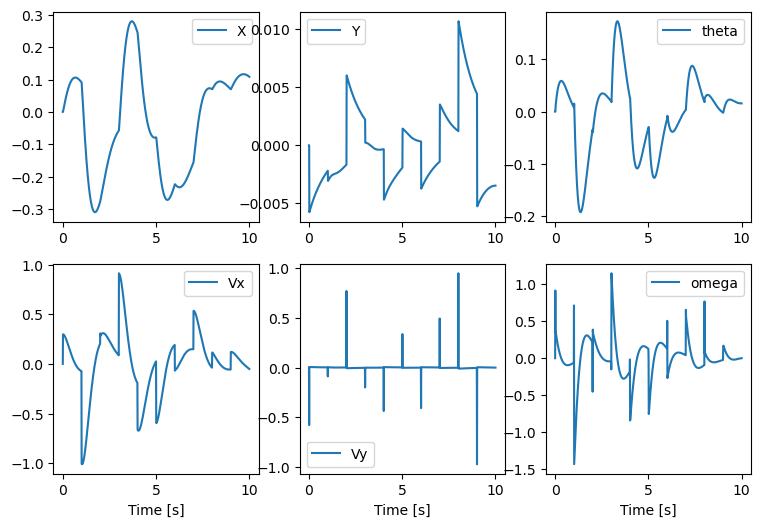

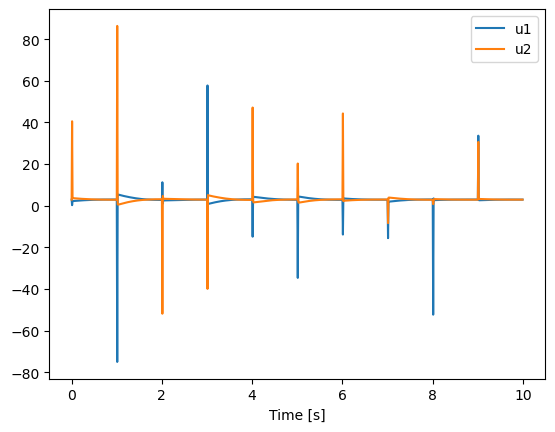

In [12]:
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')
